# Segment Every Grain

A SAM-based model for instance segmentation of images of grains

<a target="_blank" href="https://colab.research.google.com/github/zsylvester/segmenteverygrain/blob/main/segmenteverygrain/Segment_every_grain_colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Install and import packages

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!{sys.executable} -m pip install segmenteverygrain
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [2]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from importlib import reload
import segmenteverygrain as seg
from tqdm import trange

## Download Unet model weights and create Unet model

(there must be an easier way of doing this...)

In [68]:
mkdir checkpoints

In [69]:
cd checkpoints

/content/checkpoints


In [70]:
!wget "https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/segmenteverygrain/checkpoints/checkpoint"
!wget "https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/segmenteverygrain/checkpoints/seg_model.data-00000-of-00001"
!wget "https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/segmenteverygrain/checkpoints/seg_model.index"

--2023-05-25 18:31:36--  https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/segmenteverygrain/checkpoints/checkpoint
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75 [text/plain]
Saving to: ‘checkpoint’

checkpoint          100%[===================>]      75  --.-KB/s    in 0s      

2023-05-25 18:31:37 (4.25 MB/s) - ‘checkpoint’ saved [75/75]

--2023-05-25 18:31:37--  https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/segmenteverygrain/checkpoints/seg_model.data-00000-of-00001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, await

In [71]:
cd ..

/content


In [72]:
import tensorflow as tf
model = seg.Unet()
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.load_weights('./checkpoints/seg_model')

## Set up interactive figure backend in Colab

In [ ]:
# this is needed to make figures in Colab interactive
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

In [59]:
%matplotlib ipympl

## Run segmentation

Grains are supposed to be well defined in the image; e.g., if a grain consists of only a few pxiels, it is unlikely to be detected.

The segmentation can take a few minutes even for medium-sized images, so do not start with large images (downsample them if necessary).

In [57]:
# get example image
!wget "https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/images/A003_20201229_103823_image.png"

--2023-05-25 18:12:21--  https://raw.githubusercontent.com/zsylvester/segmenteverygrain/main/images/A003_20201229_103823_image.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2342693 (2.2M) [image/png]
Saving to: ‘A003_20201229_103823_image.png’

A003_20201229_10382 100%[===================>]   2.23M  --.-KB/s    in 0.06s   

2023-05-25 18:12:21 (35.8 MB/s) - ‘A003_20201229_103823_image.png’ saved [2342693/2342693]



In [62]:
fname = 'A003_20201229_103823_image.png'

big_im = np.array(load_img(fname))
big_im_pred = seg.predict_big_image(big_im, model, I=256)
# decreasing the 'dbs_max_dist' parameter results in more SAM prompts (and longer processing times):
labels, grains, coords = seg.label_grains(big_im, big_im_pred, dbs_max_dist=10.0)
all_grains, labels, mask_all, fig, ax = seg.sam_segmentation(sam, big_im, big_im_pred, coords, labels, min_area=50.0)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# plot results again if necessary
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(big_im)
seg.plot_image_w_colorful_grains(big_im, all_grains, ax, cmap='Paired')
seg.plot_grain_axes_and_centroids(all_grains, labels, ax, linewidth=1, markersize=10)

## Delete or merge grains in segmentation result
* click on the grain that you want to remove and press the 'x' key
* click on two grains that you want to merge and press the 'm' key (they have to be the last two grains you clicked on)

In [63]:
grain_inds = []
cid1 = fig.canvas.mpl_connect('button_press_event', 
                              lambda event: seg.onclick2(event, all_grains, grain_inds, ax=ax))
cid2 = fig.canvas.mpl_connect('key_press_event', 
                              lambda event: seg.onpress2(event, all_grains, grain_inds, fig=fig, ax=ax))

Run this cell if you do not want to delete / merge existing grains anymore; it is a good idea to do this before moving on to the next step.

In [64]:
fig.canvas.mpl_disconnect(cid1)
fig.canvas.mpl_disconnect(cid2)

## Add new grains using the Segment Anything Model

* click on unsegmented grain that you want to add
* press the 'x' key if you want to delete the last grain you added
* press the 'm' key if you want to merge the last two grains that you added
* right click outside the grain (but inside the most recent mask) if you want to restrict the grain to a smaller mask - this adds a background prompt

In [65]:
predictor = SamPredictor(sam)
predictor.set_image(big_im) # this can take a while
coords = []
cid3 = fig.canvas.mpl_connect('button_press_event', lambda event: seg.onclick(event, ax, coords, big_im, predictor))
cid4 = fig.canvas.mpl_connect('key_press_event', lambda event: seg.onpress(event, ax, fig))

After you are done with the deletion / addition of grain masks, run this cell to generate an updated set of grains:

100%|██████████| 121/121 [00:01<00:00, 119.09it/s]


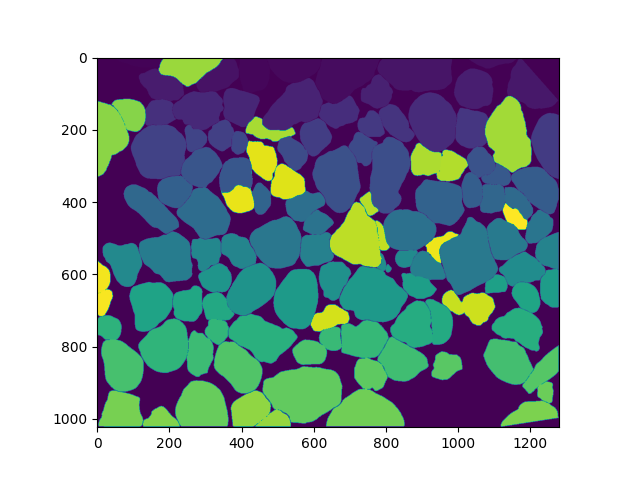

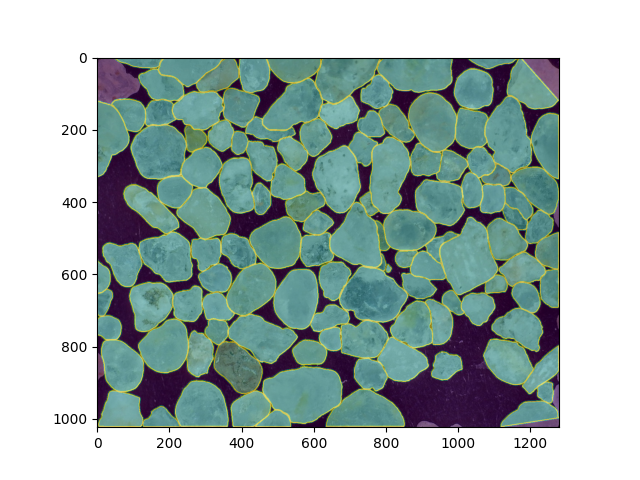

In [66]:
all_grains, labels, mask_all, fig, ax = seg.get_grains_from_patches(ax, big_im)

## Save mask and grain labels to PNG files

In [ ]:
dirname = '~/content/'
# write grayscale mask to PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_mask.png', mask_all)
# Define a colormap using matplotlib
num_classes = len(all_grains)
cmap = plt.get_cmap('viridis', num_classes)
# Map each class label to a unique color using the colormap
vis_mask = cmap(labels.astype(np.uint16))[:,:,:3] * 255
vis_mask = vis_mask.astype(np.uint8)
# Save the mask as a PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_labels.png', vis_mask)
# Save the image as a PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_image.png', cv2.cvtColor(big_im, cv2.COLOR_BGR2RGB))

True